In [65]:
pip install wordcloud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from textblob import TextBlob 
from wordcloud import WordCloud
import collections
%matplotlib inline

#### Within this project I wish to address 3 questions
#### 1. Can we use Textblob package to establish the sentiment of text reviews of AirBNB properties in Seattle?
#### 2. What are the common themes of the text reviews of AirBNB properties in Seattle?
#### 3. Can we use the features of an AirBNB property to predict its eventual review sentiment or score?

In [127]:
### ingest listings data contianing features of Seattle AirBNB properties
df_list = pd.read_csv('Downloads\seattle_airbnb\listings.csv')
df_list.shape

(3818, 92)

In [128]:
### list the features available in the dataset
df_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [129]:
### read in review of Seattle AirBnBs
df_rev = pd.read_csv('Downloads\seattle_airbnb\\reviews.csv', sep=',')
df_rev.shape

(84849, 6)

#### can we identify the most complained about thing?

In [130]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [131]:
## review column is in comments and contains nulls
## replace null with blank
df_rev['comments'].fillna("", inplace = True)

## clean comments to lower case and remove punctuation
df_rev['comments'] = df_rev.comments.str.lower()
df_rev['comments'] = df_rev.comments.str.replace(',', '')
df_rev['comments'] = df_rev.comments.str.replace("'", '')
df_rev['comments'] = df_rev.comments.str.replace("-", '')
df_rev['comments'] = df_rev.comments.str.replace(".", '')
df_rev['comments'] = df_rev.comments.str.replace("!", '')
df_rev['comments'] = df_rev.comments.str.replace("?", '')

In [132]:
## function to remove stop words (irrelevant text) from the reviews
def replace_list(df, replist, column):
    '''
    INPUT:
    df - dataframe with columns to remove stop words
    replist - list of stop words to remove from strings
    column - column with string values to remove stop words from
    
    Provides a dataframe where the stop words are removed from column strings
    '''
    col_split = df[column].str.split().tolist()
    
    for x in range(0, len(col_split)):
        col_split[x] = [elem for elem in col_split[x] if elem not in replist]
        col_split[x] = " ".join(word for word in col_split[x])
        
    df[column] = col_split
    
    return df

# replist of stop words
replist = ['for', 'an', 'a', 'of', 'and', 'in', 'the', 'to', 'from']
### remove stop words from the comments column
column = 'comments'

df_rev = replace_list(df_rev, replist, column)
df_rev['comments']

0              cute cozy place perfect location everything
1        kelly has great room very central location bea...
2        very spacious apartment great neighborhood thi...
3        close seattle center all it has offer ballet t...
4        kelly was great host very accommodating great ...
                               ...                        
84844    description pictures apartment were exactly wh...
84845    we had excellent stay it was clean comfortable...
84846    gran ubicación cerca de todo lo atractivo del ...
84847    very good apartement clean well sized situated...
84848    breanne was great host check was easy she let ...
Name: comments, Length: 84849, dtype: object

In [133]:
## create list of reviews
reviews_list = df_rev['comments'].tolist()

In [134]:
## create a list of every word in every review
word_list = df_rev['comments'].str.split().tolist()
flat_list = [item for sublist in word_list for item in sublist]

In [135]:
## create TextBlob of each review for sentiment analysis
sentiment_objects = [TextBlob(review) for review in reviews_list]

In [136]:
### create list of subjective sentiment for each review
sentiment_values = [[review.sentiment.polarity, str(review)] for review in sentiment_objects]

In [137]:
## view first review sentiment
sentiment_values[0]

[0.43333333333333335, 'cute cozy place perfect location everything']

In [138]:
## create datframe of review sentiment
sentiment_df = pd.DataFrame(sentiment_values, columns=["review_sentiment", "comments"])

In [139]:
sentiment_df[["review_sentiment", "comments"]]

,review_sentiment,comments
0,0.433333,cute cozy place perfect location everything
1,0.301136,kelly has great room very central location bea...
2,0.391667,very spacious apartment great neighborhood thi...
3,0.358333,close seattle center all it has offer ballet t...
4,0.477576,kelly was great host very accommodating great ...
...,...,...
84844,0.176875,description pictures apartment were exactly wh...
84845,0.311111,we had excellent stay it was clean comfortable...
84846,0.000000,gran ubicación cerca de todo lo atractivo del ...
84847,0.216852,very good apartement clean well sized situated...


In [140]:
### add our review sentiment scores to our review dataset
df_rev['review_sentiment'] = sentiment_df['review_sentiment']

In [141]:
df_rev[['comments', 'review_sentiment']]

,comments,review_sentiment
0,cute cozy place perfect location everything,0.433333
1,kelly has great room very central location bea...,0.301136
2,very spacious apartment great neighborhood thi...,0.391667
3,close seattle center all it has offer ballet t...,0.358333
4,kelly was great host very accommodating great ...,0.477576
...,...,...
84844,description pictures apartment were exactly wh...,0.176875
84845,we had excellent stay it was clean comfortable...,0.311111
84846,gran ubicación cerca de todo lo atractivo del ...,0.000000
84847,very good apartement clean well sized situated...,0.216852


[Text(0.5, 1.0, 'Review Sentiment from -1 to 1')]

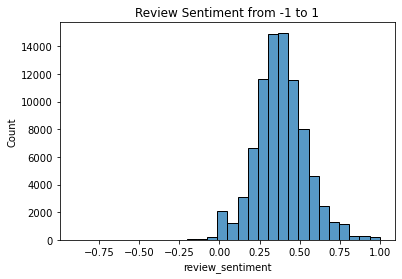

In [142]:
## histogram of review sentiment where -1 is negative and +1 is postive
sns.histplot(data=sentiment_df, x='review_sentiment', bins =30).set(title='Review Sentiment from -1 to 1')

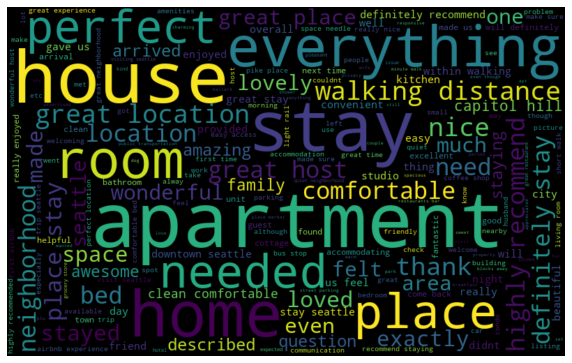

In [143]:
### most reviews appear to be positive in nature
### create wordcloud from the reviews
all_words = ' '.join([review for review in reviews_list])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [144]:
## the largest adjective words and phrases in the word cloud appear to be positive
### view commonly used words
collections.Counter(flat_list).most_common()

[('was', 163712),
 ('we', 94096),
 ('is', 89111),
 ('i', 74590),
 ('very', 71919),
 ('great', 60429),
 ('with', 54711),
 ('it', 52092),
 ('stay', 51790),
 ('place', 45223),
 ('our', 39681),
 ('were', 39157),
 ('seattle', 39086),
 ('had', 36014),
 ('this', 31752),
 ('us', 31655),
 ('you', 31416),
 ('at', 29996),
 ('my', 29993),
 ('as', 29808),
 ('clean', 29009),
 ('location', 28294),
 ('would', 26117),
 ('apartment', 25672),
 ('that', 25088),
 ('on', 24949),
 ('there', 24918),
 ('comfortable', 24916),
 ('but', 24206),
 ('nice', 22931),
 ('house', 22491),
 ('so', 22338),
 ('all', 20775),
 ('room', 20501),
 ('host', 20433),
 ('again', 20115),
 ('home', 19755),
 ('everything', 19647),
 ('she', 18484),
 ('have', 18330),
 ('are', 18123),
 ('neighborhood', 17996),
 ('easy', 17857),
 ('time', 17641),
 ('her', 17123),
 ('recommend', 16431),
 ('really', 16249),
 ('perfect', 16038),
 ('downtown', 15503),
 ('if', 15483),
 ('definitely', 15294),
 ('be', 15201),
 ('well', 15173),
 ('not', 14556),
 (

In [145]:
#### from the word cloud and list of most common words we see adjectives in relation to cleanliness and location appear to rank high 

## function to count specific word use and plot on bar chart
def word_phrase_count(phrase, sentiment_objects):
    '''
    INPUT:
    phrase - list of words or phrases to count
    sentiment_objects - list of textblob objects
    
    Provides a dataframe of counts and bar chart
    '''
    word_count_tot = []
    for x in phrase:
        word_count = [0 if review.find(str(x)) == -1 else 1 for review in sentiment_objects]
        word_count_tot.append(word_count)
    df = pd.DataFrame(word_count_tot)
    df = df.transpose()
    df = df.sum()
    df.index = phrase
    
    print(df.plot.barh())
    
    print(df)
    return df

AxesSubplot(0.125,0.125;0.775x0.755)
quiet               11794
downtown            14723
location            27169
walking distance     6833
dirty                 211
clean               28881
convenient           8318
comfortable         23423
loud                  661
highly recommend     7694
great location       6786
dtype: int64


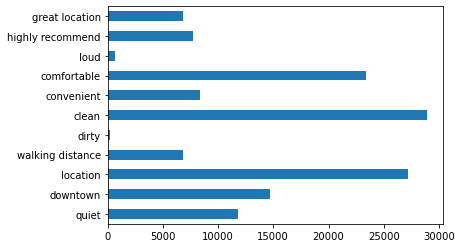

In [146]:
## some commonly used phrases and words
phrase = ['quiet', 'downtown', 'location', 'walking distance','dirty', 'clean', 'convenient', 'comfortable', 'loud', 'highly recommend', 'great location']
df = word_phrase_count(phrase, sentiment_objects)

In [289]:
### clean, comfortable and location have large counts

In [148]:
sum(isinstance(x, str) for x in reviews_list)

84849

In [149]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        84849 non-null  int64  
 1   id                84849 non-null  int64  
 2   date              84849 non-null  object 
 3   reviewer_id       84849 non-null  int64  
 4   reviewer_name     84849 non-null  object 
 5   comments          84849 non-null  object 
 6   review_sentiment  84849 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 4.5+ MB


In [150]:
### check our review properties appear in our list set
df_rev[df_rev.listing_id.isin(df_list.id)].count()

listing_id          84849
id                  84849
date                84849
reviewer_id         84849
reviewer_name       84849
comments            84849
review_sentiment    84849
dtype: int64

In [151]:
### renaming id column in our listing dataset so it is consistent with our 
df_list = df_list.rename(columns={"id": "listing_id"})

In [152]:
df_sent = df_rev[['listing_id', 'review_sentiment']]

<AxesSubplot:>

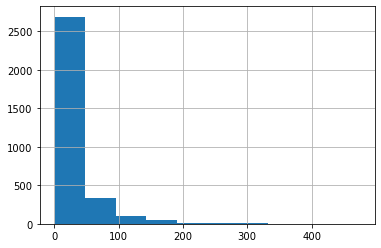

In [153]:
## look at number of occasions a property gets a review
df_sent['listing_id'].value_counts().hist()

In [291]:
### average the review sentiment for each property
df_sent_agg = df_sent.groupby('listing_id').agg(['mean', 'count'])

In [292]:
### change column names
df_sent_agg.columns = df_sent_agg.columns.get_level_values(1)
df_sent_agg = df_sent_agg.rename(columns={"mean": "review_sentiment", 'count':'review_data_count'})
df_sent_agg

,review_sentiment,review_data_count
listing_id,,
4291,0.361017,35
5682,0.347449,297
6606,0.352165,52
7369,0.417516,40
9419,0.324973,79
...,...,...
9995551,0.691667,1
10012724,0.351215,2
10020221,0.400000,1


In [157]:
### count the total number of reviews as described in the listing set
df_list.number_of_reviews.sum()

84849

In [158]:
### count the reviews in our aggregated review set
df_sent_agg.review_data_count.sum()

84849

In [159]:
#### review counts are the same in both sets so we are good to join our average property sentiments to our listing dataset
df_list = df_list.join(df_sent_agg, on=['listing_id'], how='left')

In [160]:
df_list.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type',

In [161]:
### set our review set to the columns relevant to reviews and view correlations in a plot
### drop nulls
df_review = df_list[['number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month', 'review_sentiment', 'review_data_count']].dropna()

df_review.corr().style.background_gradient(cmap='inferno')

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,review_sentiment,review_data_count
number_of_reviews,1.000000,0.036405,0.066314,0.055959,0.089612,0.072671,-0.009217,0.044211,0.559215,-0.005103,1.000000
review_scores_rating,0.036405,1.000000,0.622438,0.642380,0.521914,0.543626,0.368714,0.696288,0.087357,0.303032,0.036405
review_scores_accuracy,0.066314,0.622438,1.000000,0.544217,0.407205,0.423786,0.268242,0.563959,0.143137,0.237975,0.066314
review_scores_cleanliness,0.055959,0.642380,0.544217,1.000000,0.398625,0.388338,0.278428,0.524236,0.134599,0.194750,0.055959
review_scores_checkin,0.089612,0.521914,0.407205,0.398625,1.000000,0.696322,0.241397,0.403223,0.123397,0.244077,0.089612
review_scores_communication,0.072671,0.543626,0.423786,0.388338,0.696322,1.000000,0.285033,0.464171,0.104914,0.272745,0.072671
review_scores_location,-0.009217,0.368714,0.268242,0.278428,0.241397,0.285033,1.000000,0.369699,0.062163,0.185275,-0.009217
review_scores_value,0.044211,0.696288,0.563959,0.524236,0.403223,0.464171,0.369699,1.000000,0.126347,0.228162,0.044211
reviews_per_month,0.559215,0.087357,0.143137,0.134599,0.123397,0.104914,0.062163,0.126347,1.000000,0.025492,0.559215
review_sentiment,-0.005103,0.303032,0.237975,0.194750,0.244077,0.272745,0.185275,0.228162,0.025492,1.000000,-0.005103


In [293]:
#### we see the correlation for review sentiment to review score rating is 0.3.
### it is a positve correlation as we would expect but it isn't particularly strong, maybe our textblob sentiment model could be further refined

<AxesSubplot:>

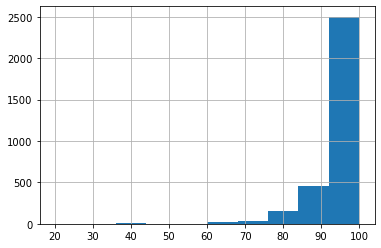

In [163]:
### plot the distibrution of review scores for the properties
df_review.review_scores_rating.hist()

<AxesSubplot:xlabel='review_scores_rating', ylabel='review_sentiment'>

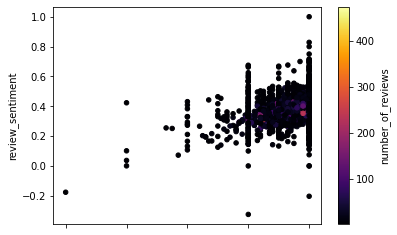

In [164]:
### we see the there is strong right skew for our reviews
### this aligns with our sentiment analysis the reviews are largely positive

### lets plot our review scores next to our sentiment analysis on a scatter plot and shade by the number of reviews each property has received
df_review.plot.scatter(x='review_scores_rating', y='review_sentiment', c='number_of_reviews', cmap='inferno')

<AxesSubplot:xlabel='review_scores_rating', ylabel='review_sentiment'>

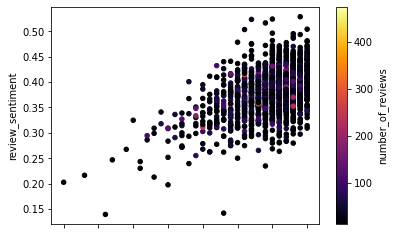

In [165]:
### we can see from the darkness of the chart that most properties don't have many reviews
### for a strong correlation between our sentiment analysis we would hope for the review sentiment to increase in line with score from left to right
### in fact we see that as our review sentiment approaches 0.4 most properties are getting 8-10 review scores
### sentiment analysis could further fine tuned
### properties with only one review could be skewing our data

#### lets just plot properties who have more than 10 reviews
df_review[df_review.number_of_reviews > 10].plot.scatter(x='review_scores_rating', y='review_sentiment', c='number_of_reviews', cmap='inferno')

In [166]:
### we see in the above plot an improved correlation when we look at properties with more than 10 reviews

### correlation matrix for properties with more than 100 reviews
df_review[df_review.number_of_reviews > 100].corr().style.background_gradient(cmap='inferno')

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,review_sentiment,review_data_count
number_of_reviews,1.000000,0.029301,0.043033,0.075918,-0.024137,-0.003506,-0.109260,0.030242,0.332126,-0.047226,1.000000
review_scores_rating,0.029301,1.000000,0.752635,0.751315,0.696951,0.643354,0.387562,0.707761,-0.119906,0.400027,0.029301
review_scores_accuracy,0.043033,0.752635,1.000000,0.553898,0.479115,0.391002,0.178900,0.591811,-0.075877,0.246359,0.043033
review_scores_cleanliness,0.075918,0.751315,0.553898,1.000000,0.485152,0.383238,0.134767,0.569956,-0.092993,0.102394,0.075918
review_scores_checkin,-0.024137,0.696951,0.479115,0.485152,1.000000,0.632184,0.235690,0.403387,-0.148364,0.277492,-0.024137
review_scores_communication,-0.003506,0.643354,0.391002,0.383238,0.632184,1.000000,0.278061,0.323211,-0.112494,0.328408,-0.003506
review_scores_location,-0.109260,0.387562,0.178900,0.134767,0.235690,0.278061,1.000000,0.211852,-0.049842,0.542856,-0.109260
review_scores_value,0.030242,0.707761,0.591811,0.569956,0.403387,0.323211,0.211852,1.000000,-0.121003,0.171525,0.030242
reviews_per_month,0.332126,-0.119906,-0.075877,-0.092993,-0.148364,-0.112494,-0.049842,-0.121003,1.000000,0.094732,0.332126
review_sentiment,-0.047226,0.400027,0.246359,0.102394,0.277492,0.328408,0.542856,0.171525,0.094732,1.000000,-0.047226


In [ ]:
### notably as we look at properties with more reviews, we see the correlation between review sentiment and review score increases, this will be as properties that are positively reviewed more often are more likely to highest sentiment rating
### in the review text. Also as we look at properties with more than 100 reviews we see the correlations between sentiment and location score growing strong
### this makes sense in the context of our word cloud where location was key factor in the generally positive reviews.

### sentiment analysis of descriptions

In [167]:
### lets also produce a sentiment analysis of the property descriptions
df_decrip = df_list[['listing_id', 'name', 'summary', 'space']]

In [168]:
df_decrip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   listing_id  3818 non-null   int64 
 1   name        3818 non-null   object
 2   summary     3641 non-null   object
 3   space       3249 non-null   object
dtypes: int64(1), object(3)
memory usage: 119.4+ KB


In [169]:
## clean comments to lower case and remove punctuation
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace('nan', ''))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.lower())
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace(',', ''))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace("'", ''))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace('-', ' '))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace('/', ' '))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace('.', ''))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace('?', ''))
df_decrip = df_decrip.apply(lambda x: x.astype(str).str.replace('!', ''))

In [170]:
for x in df_decrip.columns:
    df_decrip = replace_list(df_decrip, replist, str(x))

In [171]:
df_decrip

,listing_id,name,summary,space
0,241032,stylish queen anne apartment,,make your self at home this charming one bedro...
1,953595,bright & airy queen anne apartment,chemically sensitive weve removed irritants tr...,beautiful hypoallergenic apartment extremely s...
2,3308979,new modern house amazing water view,new modern house built 2013 spectacular sunset...,our house is modern light fresh with warm simp...
3,7421966,queen anne chateau,charming apartment that sits atop queen anne h...,
4,278830,charming craftsman 3 bdm house,cozy family craftman house beautiful neighborh...,cozy family craftman house beautiful neighborh...
...,...,...,...,...
3813,8101950,3br mountain view house seattle,our 3br 2ba house boasts incredible views olym...,our 3br 2ba house bright stylish wheelchair ac...
3814,8902327,portage bay view one bedroom apt,800 square foot 1 bedroom basement apartment w...,this space has great view portage bay with all...
3815,10267360,private apartment view lake wa,very comfortable lower unit quiet charming mid...,
3816,9604740,amazing view with modern comfort,cozy studio condo heart on madison park on lak...,fully furnished unit accommodate most needs we...


In [172]:
### lets produce a function to perform sentiment analyis like we did with reviews

def text_sentiment(df, col):
    '''
    INPUT:
    df - dataframe containing columns for sentiment analysis
    col - column to perform sentiment analysis on
    
    Provides a dataframe with the sentiment analysis of the column 
    '''
    ## create TextBlob of each review for sentiment analysis
    text_list = df[col].tolist()
    sentiment_objects = [TextBlob(text) for text in text_list]
    ### create list of subjective sentiment for each review
    sentiment_values = [[text.sentiment.polarity, str(text)] for text in sentiment_objects]
    
    sentiment_df = pd.DataFrame(sentiment_values, columns=[col + "_sentiment", col])
    
    return sentiment_df

In [173]:
text_cols = ['name', 'summary', 'space']

### perform sentiment analyis on the columns stated above
for x in text_cols:
    sent_df = text_sentiment(df_decrip, str(x))
    df_list[str(x) + '_sentiment'] = sent_df[str(x) + '_sentiment']
    

In [174]:
### look at the features within our data now
df_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 97 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   listing_id                        3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [256]:
### examine some of the key features in our set

df_list[['neighbourhood_cleansed',
       'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'review_sentiment',
        'name_sentiment', 'summary_sentiment', 'space_sentiment', 'name_sentiment', 'instant_bookable']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        3818 non-null   object 
 1   neighbourhood_group_cleansed  3818 non-null   object 
 2   property_type                 3818 non-null   object 
 3   room_type                     3818 non-null   object 
 4   accommodates                  3818 non-null   int64  
 5   bathrooms                     3818 non-null   float64
 6   bedrooms                      3818 non-null   float64
 7   beds                          3818 non-null   float64
 8   bed_type                      3818 non-null   object 
 9   amenities                     3818 non-null   object 
 10  price                         3818 non-null   float64
 11  security_deposit              3818 non-null   float64
 12  cleaning_fee                  3818 non-null   float64
 13  gue

In [176]:
### clean the property_type and review sentiment fields for those without reviews or property type given
df_list['property_type'].fillna("Other", inplace = True)
df_list['review_sentiment'].fillna(0, inplace = True)

In [177]:
### clean the currency columns within the data
df_list[['price', 'security_deposit', 'cleaning_fee', 'extra_people']] = df_list[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',',''))
df_list[['price', 'security_deposit', 'cleaning_fee', 'extra_people']] = df_list[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].apply(pd.to_numeric)

In [261]:
#### fill null column values for out floats with the average

fill_mean = lambda col: col.fillna(col.mean())
df_list[['review_sentiment', 'beds', 'bathrooms', 'bedrooms', 'price', 'security_deposit', 'cleaning_fee', 'extra_people', 'review_scores_value']] = df_list[['review_sentiment', 'beds', 'bathrooms', 'bedrooms', 'price', 'security_deposit', 'cleaning_fee', 'extra_people', 'review_scores_value']].apply(fill_mean, axis=0)

In [262]:
#### lets examine columns again for nulls
df_list[['neighbourhood_cleansed',
       'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'review_sentiment',
        'name_sentiment', 'summary_sentiment', 'space_sentiment', 'name_sentiment', 'review_scores_value', 
        'requires_license', 'instant_bookable', 'cancellation_policy']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        3818 non-null   object 
 1   neighbourhood_group_cleansed  3818 non-null   object 
 2   property_type                 3818 non-null   object 
 3   room_type                     3818 non-null   object 
 4   accommodates                  3818 non-null   int64  
 5   bathrooms                     3818 non-null   float64
 6   bedrooms                      3818 non-null   float64
 7   beds                          3818 non-null   float64
 8   bed_type                      3818 non-null   object 
 9   amenities                     3818 non-null   object 
 10  price                         3818 non-null   float64
 11  security_deposit              3818 non-null   float64
 12  cleaning_fee                  3818 non-null   float64
 13  gue

In [269]:
### create list of some of our feature set

model_col_list = ['neighbourhood_cleansed',
       'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_sentiment',
        'name_sentiment', 'summary_sentiment', 'space_sentiment',
        'review_scores_value', 'requires_license', 'instant_bookable', 'cancellation_policy']

In [270]:
#### lets break the amenity lists for each property into categoricals

df_split_amen = df_list['amenities'].str.split(",", expand=True)
df_split_amen = df_split_amen.apply(lambda x: x.astype(str).str.replace('"', ''))
df_split_amen = df_split_amen.apply(lambda x: x.astype(str).str.replace('{', ''))
df_split_amen = df_split_amen.apply(lambda x: x.astype(str).str.replace('}', ''))
df_split_amen = df_split_amen.apply(lambda x: x.astype(str).str.replace('(', ''))
df_split_amen = df_split_amen.apply(lambda x: x.astype(str).str.replace(')', ''))
amenity_list = list(pd.unique(df_split_amen.values.ravel('K')))
amenity_list.remove('nan')
amenity_list.remove('')
model_col_list = model_col_list + amenity_list

for x in amenity_list:
    df_list[str(x)] = df_split_amen.apply(lambda r: r.astype('string').str.contains(str(x)).any(), axis=1).astype(int)

In [271]:
#### list our other columns for categorical encoding
obj_cols = list(df_list[model_col_list].select_dtypes(['object']).columns)
obj_cols

['neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'calendar_updated',
 'has_availability',
 'requires_license',
 'instant_bookable',
 'cancellation_policy']

In [272]:
#### apply categorical encoding
df_model_set = pd.get_dummies(data =df_list[model_col_list], columns=obj_cols)

In [273]:
df_model_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 231 entries, accommodates to cancellation_policy_strict
dtypes: float64(12), int32(41), int64(9), uint8(169)
memory usage: 1.8 MB


In [274]:
df_model_set.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights',
       ...
       'calendar_updated_never', 'calendar_updated_today',
       'calendar_updated_yesterday', 'has_availability_t',
       'requires_license_f', 'instant_bookable_f', 'instant_bookable_t',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict'],
      dtype='object', length=231)

In [275]:
### lets view our feture set
list(df_model_set.corr().columns)

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_sentiment',
 'name_sentiment',
 'summary_sentiment',
 'space_sentiment',
 'review_scores_value',
 'TV',
 'Internet',
 'Wireless Internet',
 'Cable TV',
 'Air Conditioning',
 'Kitchen',
 'Elevator in Building',
 'Wheelchair Accessible',
 'Smoke Detector',
 'Free Parking on Premises',
 'Pool',
 'Pets live on this property',
 'Breakfast',
 'Gym',
 'Heating',
 'Washer',
 'Buzzer/Wireless Intercom',
 'Smoking Allowed',
 'Carbon Monoxide Detector',
 'Pets Allowed',
 'Indoor Fireplace',
 'Dryer',
 'Dogs',
 'Family/Kid Friendly',
 'Hot Tub',
 'Cats',
 'Essentials',
 'Shampoo',
 'First Aid Kit',
 'Doorman',
 'Fire Extinguisher',
 'Safety Card',
 'Washer / Dryer',
 'Suitable for Events',
 'Other pets',
 'Hangers'

In [295]:
#### construct correlations with review sentiment
df_model_corr = df_model_set.corr()['review_sentiment']

In [300]:
#### view sorted correlations
df_model_corr.map(lambda x : x).abs().sort_values(ascending = False).head(10)

review_sentiment                1.000000
number_of_reviews               0.235387
cancellation_policy_flexible    0.231844
space_sentiment                 0.158295
calendar_updated_never          0.120515
cancellation_policy_strict      0.117036
Wireless Internet               0.112775
Heating                         0.107891
Lock on Bedroom Door            0.107436
Carbon Monoxide Detector        0.107204
Name: review_sentiment, dtype: float64

In [ ]:
#### now lets produce a model with this datset to establish if we can predict scores and sentiment from these features

In [304]:
### First peak rank analysis
predict_col = 'review_sentiment'

feat_vars = list(df_model_set.columns)
feat_vars.remove(predict_col)

#split data to feature and target
X = df_model_set[df_model_set.number_of_reviews > 10][feat_vars]
y = df_model_set[df_model_set.number_of_reviews > 10][predict_col]

### train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True) 

##fit the model
lm_model.fit(X_train, y_train) 

y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train)

test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [305]:
test_score

-1.352676256327663e+27

In [306]:
#### the model is a poor fit for the test set and only slight for our training set when viewing properties with more than 10 reviews
train_score

0.3264145391842811

In [307]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
127,neighbourhood_cleansed_Roxhill,-4.055335e+13,4.055335e+13
63,neighbourhood_cleansed_Arbor Heights,-2.006822e+13,2.006822e+13
120,neighbourhood_cleansed_Pinehurst,-1.424385e+13,1.424385e+13
171,property_type_Chalet,1.250034e+13,1.250034e+13
173,property_type_Dorm,1.185160e+13,1.185160e+13
94,neighbourhood_cleansed_Interbay,1.139639e+13,1.139639e+13
155,neighbourhood_group_cleansed_Interbay,-1.065018e+13,1.065018e+13
72,neighbourhood_cleansed_Cedar Park,1.040780e+13,1.040780e+13
106,neighbourhood_cleansed_Meadowbrook,1.040780e+13,1.040780e+13
138,neighbourhood_cleansed_Victory Heights,1.040780e+13,1.040780e+13
